In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
from matplotlib import pyplot as plt
from moviepy.editor import *
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

  if event.key is 'enter':



In [ ]:
seed_constant = 10
random.seed(seed_constant)
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
plt.figure(figsize=(20, 20))

all_classes_names = os.listdir('/content/drive/MyDrive/videos/train')

all_classes_names

['close 1.mp4',
 'open 1.mp4',
 'close 2.mp4',
 'open 2.mp4',
 'close 3.mp4',
 'open 3.mp4',
 'close 4.mp4',
 'open 4.mp4',
 'close 5.mp4',
 'open 5.mp4',
 'close 6.mp4',
 'open 6.mp4',
 'open 7.mp4',
 'close 7.mp4',
 'open 8.mp4',
 'open 9.mp4',
 'close 8.mp4',
 'open 10.mp4',
 'close 9.mp4',
 'open 11.mp4',
 'close 11.mp4',
 'open 12.mp4',
 'close 13.mp4',
 'open 13.mp4',
 'close 14.mp4',
 'open 15.mp4',
 'close 15.mp4',
 'open 16.mp4',
 'close 16.mp4',
 'open 14.mp4',
 'close 19.mp4',
 'open 18.mp4',
 'close 10.mp4',
 'close 17.mp4',
 'open 19.mp4',
 'close 18.mp4',
 'open 20.mp4',
 'close 21.mp4',
 'open 21.mp4',
 'close 22.mp4',
 'open 22.mp4',
 'close 20.mp4',
 'open 23.mp4',
 'close 23.mp4',
 'open 24.mp4',
 'close 24.mp4',
 'open 25.mp4',
 'close 25.mp4',
 'open 26.mp4',
 'close 26.mp4',
 'open 27.mp4',
 'open 28.mp4',
 'close 27.mp4',
 'open 29.mp4',
 'close 29.mp4',
 'open 30.mp4',
 'close 30.mp4',
 'open 31.mp4',
 'close 32.mp4',
 'open 32.mp4',
 'close 31.mp4',
 'open 33.mp

<Figure size 2000x2000 with 0 Axes>

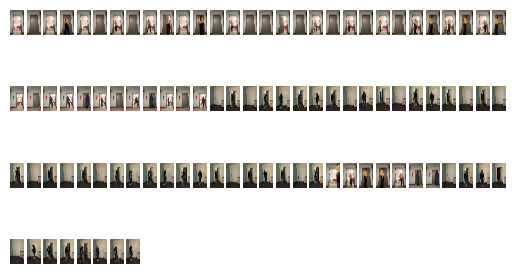

In [ ]:
for count, file_name in enumerate(all_classes_names):
  video_reader = cv2.VideoCapture('/content/drive/MyDrive/videos/train/' + file_name)
  _, bgr_frame = video_reader.read()
  video_reader.release()

  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, file_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  plt.subplot(5, 30, count+1)
  plt.imshow(rgb_frame)
  plt.axis('off')

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20
DATASET_DIR = '/content/drive/MyDrive/videos/train'
CLASSES_LIST = ['open', 'close']


In [ ]:
! pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.7/112.6 GB disk)


In [ ]:
from ultralytics import YOLO
yolo_model = YOLO('/content/drive/MyDrive/videos/best.pt')

In [ ]:
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  print(video_path)

  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    success, frame = video_reader.read()
    if not success:
      print(frame_counter)
      break
    resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list

def frames_extraction2(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  # get the frame interval
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  success, frame = video_reader.read()
  frame_count = 0
  print(video_path)

  while success:
    if frame_count % skip_frames_window == 0:
      results = yolo_model.predict(frame)
      boxes = results[0].boxes.xyxy.cpu().tolist()
      clss = results[0].boxes.cls.cpu().tolist()

      for box, cls in zip(boxes, clss):  # Iterate over detected objects
        x1, y1, x2, y2 = box
        print(cls)
        if cls == 0:  # Class ID for "door" (check trained labels)
          cropped_door = frame[int(y1):int(y2), int(x1):int(x2)]

          resized_frame = cv2.resize(cropped_door, (IMAGE_WIDTH, IMAGE_HEIGHT))
          normalized_frame = resized_frame / 255
          frames_list.append(normalized_frame)
    frame_count += 1
    success, frame = video_reader.read()
  video_reader.release()
  return frames_list

In [ ]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = os.listdir(DATASET_DIR)
  for video_file_path in video_files_paths:
    frames = frames_extraction(DATASET_DIR + '/' + video_file_path)
    if len(frames) == SEQUENCE_LENGTH:
      features.append(frames)
      label = "open" if "open" in video_file_path else "close"
      labels.append(CLASSES_LIST.index(label))
    else:
      print("####################Unable to read:" + video_file_path)
  features = np.asarray(features)
  labels = np.array(labels)
  return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()
one_hot_encoded_labels = to_categorical(labels)

/content/drive/MyDrive/videos/train/close 1.mp4
/content/drive/MyDrive/videos/train/open 1.mp4
/content/drive/MyDrive/videos/train/close 2.mp4
/content/drive/MyDrive/videos/train/open 2.mp4
/content/drive/MyDrive/videos/train/close 3.mp4
/content/drive/MyDrive/videos/train/open 3.mp4
/content/drive/MyDrive/videos/train/close 4.mp4
/content/drive/MyDrive/videos/train/open 4.mp4
/content/drive/MyDrive/videos/train/close 5.mp4
/content/drive/MyDrive/videos/train/open 5.mp4
/content/drive/MyDrive/videos/train/close 6.mp4
/content/drive/MyDrive/videos/train/open 6.mp4
/content/drive/MyDrive/videos/train/open 7.mp4
/content/drive/MyDrive/videos/train/close 7.mp4
/content/drive/MyDrive/videos/train/open 8.mp4
/content/drive/MyDrive/videos/train/open 9.mp4
/content/drive/MyDrive/videos/train/close 8.mp4
/content/drive/MyDrive/videos/train/open 10.mp4
/content/drive/MyDrive/videos/train/close 9.mp4
/content/drive/MyDrive/videos/train/open 11.mp4
/content/drive/MyDrive/videos/train/close 11.mp4


In [ ]:
features.shape, one_hot_encoded_labels.shape

((98, 20, 64, 64, 3), (98, 2))

In [ ]:

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1, shuffle = True, random_state = seed_constant)

In [ ]:
len(labels_train), len(features_test)

(88, 10)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))
  plt.legend()
  plt.show()


# Implement the LRCN Approach
Here we will use time-distributed Conv2D layers hich will be followed by `MaxPooling2D` and `Dropout`layers. The feature extracted from the `Conv2D` layers will be then flattened using the `Flatten`layer and will be fed to a `LSTM` layer. The `Dense` layer with softmax activation will then use the output from the `LSTM` layer to predict the action being performed.

In [ ]:
def create_LRCN_model():
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  model.summary()
  return model

In [ ]:
LRCN_model = create_LRCN_model()

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 16, 16, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 4, 4, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,642 (236.88 KB)

 Trainable params: 60,642 (236.88 KB)

 Non-trainable params: 0 (0.00 B)

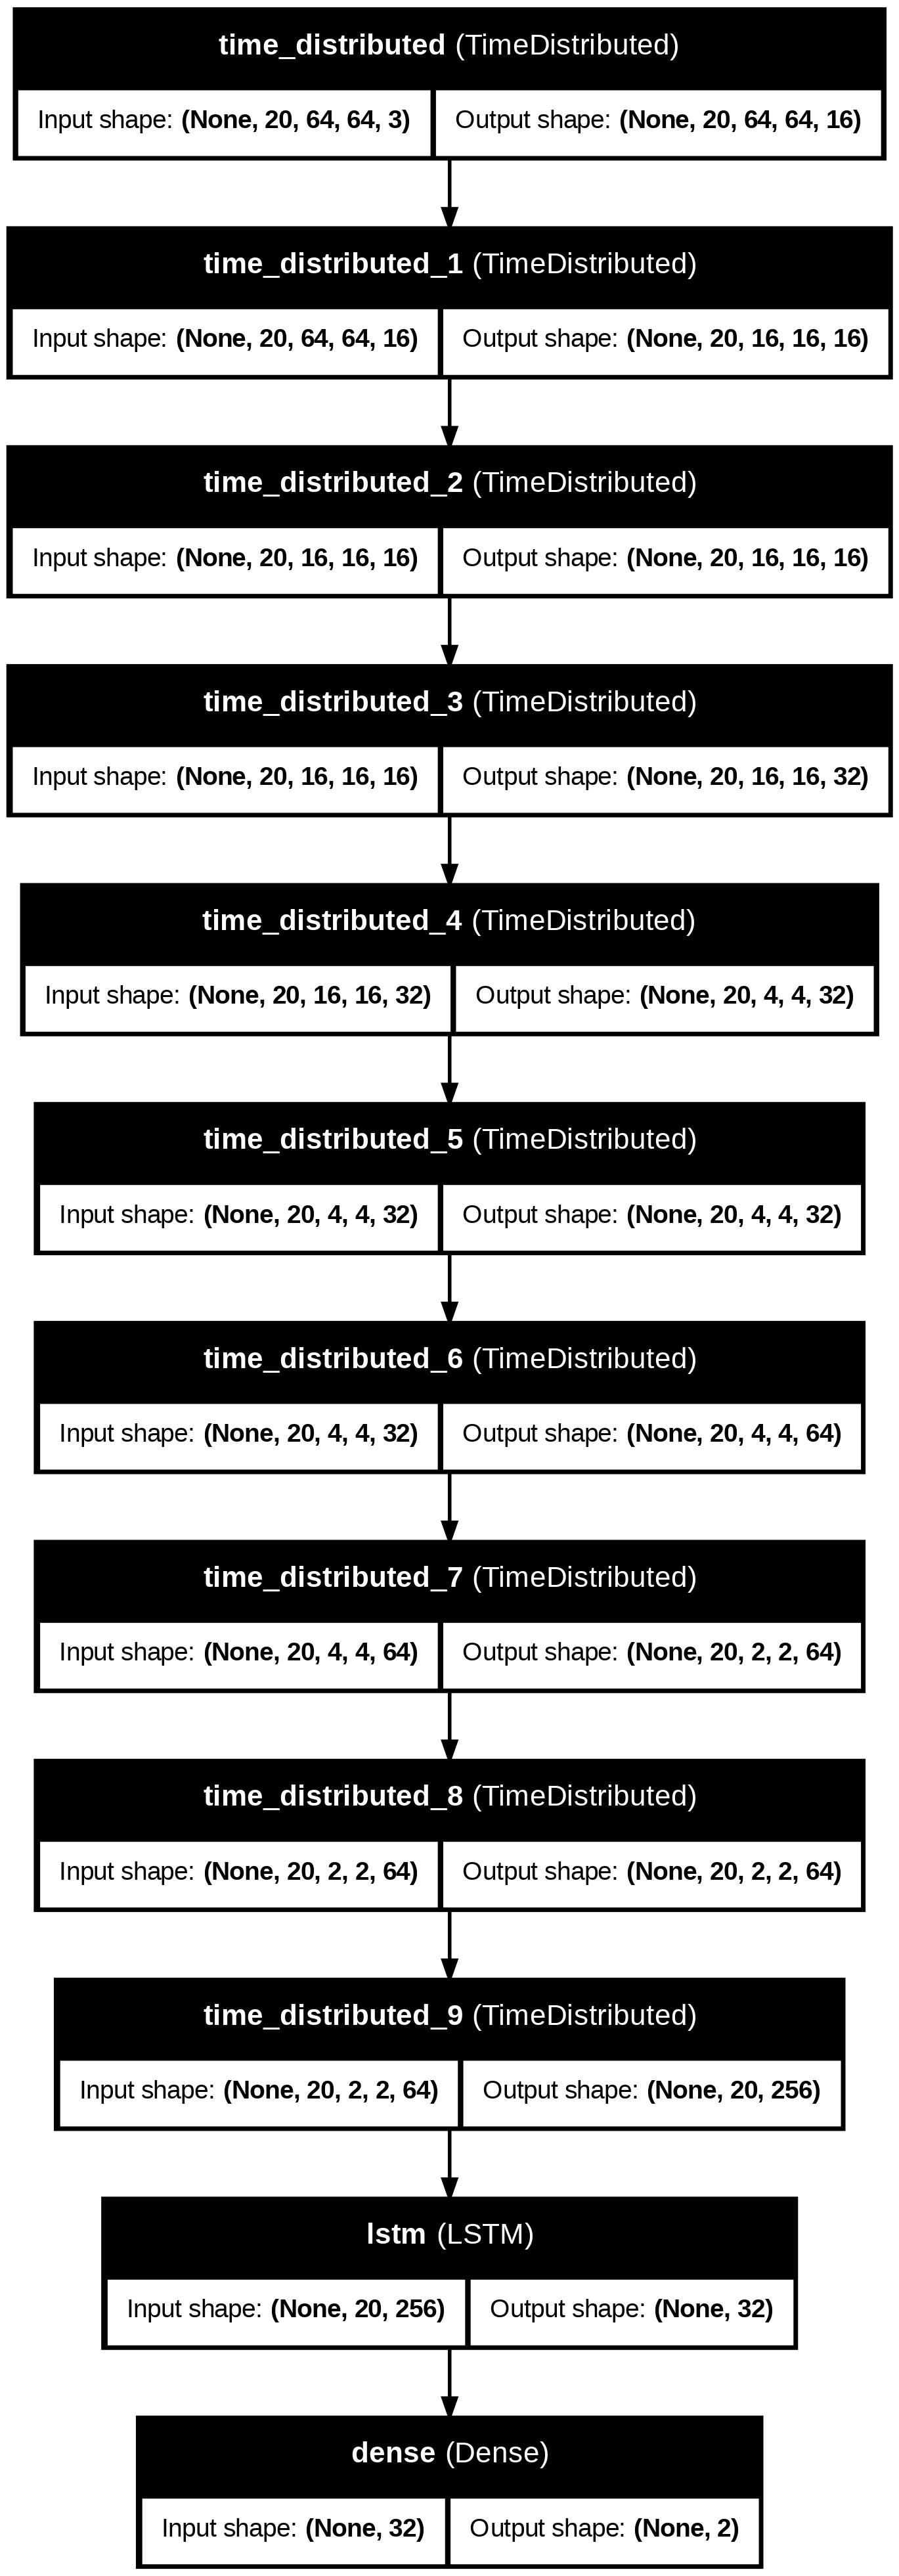

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 5 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.4381 - loss: 0.7743 - val_accuracy: 0.5556 - val_loss: 0.6978
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5052 - loss: 0.7040 - val_accuracy: 0.5000 - val_loss: 0.6866
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6692 - loss: 0.6698 - val_accuracy: 0.5556 - val_loss: 0.6763
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6690 - loss: 0.6521 - val_accuracy: 0.5556 - val_loss: 0.6588
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7860 - loss: 0.6194 - val_accuracy: 0.5556 - val_loss: 0.6084
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8238 - loss: 0.5406 - val_accuracy: 0.8889 - val_loss: 0.4767
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8405 - loss: 0.3854 - val_accuracy: 0.8889 - val_loss: 0.4009
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8928 - loss: 0.3097 - val_accuracy: 0.8889 -

In [ ]:
labels_test

array([[          1,           0],
       [          1,           0],
       [          0,           1],
       [          0,           1],
       [          0,           1],
       [          1,           0],
       [          1,           0],
       [          0,           1],
       [          1,           0],
       [          0,           1]])

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.1116


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format  = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

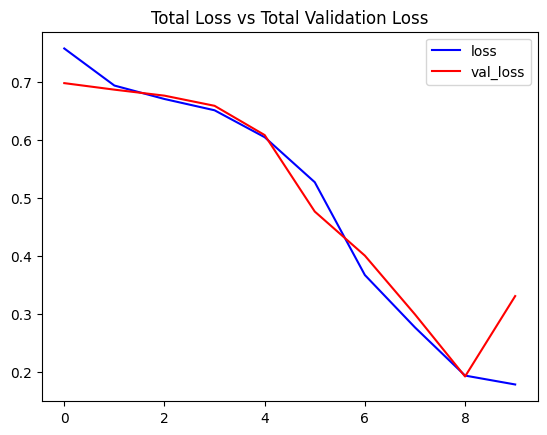

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

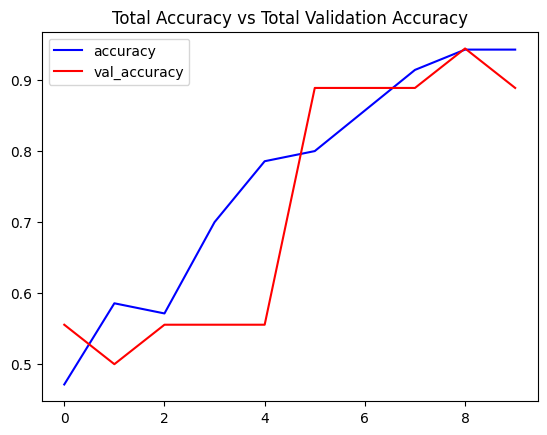

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Test video

In [ ]:
test_videos_directory = '/content/drive/MyDrive/videos/test/'
all_test_videos_filenames = os.listdir(test_videos_directory)

In [ ]:
from google.colab.patches import cv2_imshow

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    if not video_reader.isOpened():
        print(f"Error: Unable to open video {video_file_path}")
        return

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   fps, (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    frame_count = 0

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label] + " : " + str(round(predicted_labels_probabilities[predicted_label] * 100, 2))
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)
        frame_count += 1

    video_reader.release()
    video_writer.release()

In [ ]:
for count, file_name in enumerate(all_test_videos_filenames):
    input_path = os.path.join(test_videos_directory, file_name)
    output_path = os.path.join('/content/drive/MyDrive/videos/predicted_videos/', file_name)
    predict_on_video(input_path, output_path, SEQUENCE_LENGTH)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step